## CS421 PROJECT

### Data and Task

In this project, you will be working with data extracted from a recommender systems type dataset: you are provided with a large set of interactions between subjects (e.g., online shopping users, or social network users)  and items (e.g., shopping items, books, songs, or movies). Whenever a user "interacts" with an item, he/she has some experience the item (e.g., purchase the items, read the book, listen the songs, or watch the movie) and gives a mark or "rating" between 0 and 5 stars (5 stars indicating the best experience, and 1 or 0 stars indicating that the user didn't like the experience at all).




In this exercise, we will **not** be performing the recommendation task per se. Instead, we will identify *anomalous users*. In the dataset that you are provided with, some of the data was corrupted. Whilst most of the data comes from real life user-item interactions from a real-world application, some "users" are anomalous: they were generated by me according to some undisclosed procedure to simulate exceptional users with unexpected interactions. Most users have normal, expected interactions in real applications, so the anomalous users only account for a very small proportion of the users. Thus, identifying those anomalous users are important to the application, but it can be very challenging.

You are provided with two data frames: the first one ("ratings") contains the interactions provided to you, and the second one ("labels") contains the labels for the users. There is a set of 1,200 unique items the users interact with, ranging from item ID of 0 to item ID 1199, which is fixed throughout the competition. Note that it is not necessarily that all items appear in one set of data samples given during the competition, meaning that some of the items may not be rated by any user in a user set within a specific period of time.

As you can see, the three columns in "ratings" correspond to the user ID, the item ID and the rating. Thus, each row of "ratings" contains a single interaction. For instance, if the row "142, 152, 5" is present, this means that the user with ID 142 has given the movie 152 the rating 5 stars.

The dataframe "labels" has two columns. In the first column we have the user ids, whilst the second column contains the labels. A label of 1 indicates that the user is 'anomalous', whilst a label of 0 denotes a natural, normal user (coming from real life interactions).

For instance, if the labels matrix contains the line "142, 1", it means that all of the ratings given by the user with id 142 is an anomalous user. This means all lines in the dataframe "ratings" which start with the userID 142 correspond to fake interactions.

### Evaluation

Your task is to be able to classify unseen instances as either anomalies or non anomalies.

There are **far more** normal users than anomalies in the dataset, which makes this a very heavily **unbalanced dataset**. Thus, accuracy will not be a good measure of performance, since simply predicting that every user is normal will give good accuracy. Thus, we need to use some other evaluation metrics (see lecture notes from week 3).

Suitable **EVALUATION METRICS** include: **AUC** (AREA UNDER CURVE), **PRECISION**, **RECALL**, and **F1 score**. The **main metric** will be the **AREA UNDER CURVE**, and it will by default be used to rank teams. This means your programs should return an **anomaly score** for each user (the higher the score, the more likely the model think the sample is anomalous).  

Before Week 9, each team is required to develop a model using the data "training_data_with_labels.npz" that contains labeled data. You can leverage the data in whatever the way you believe is right. Thereafter every week, we will evaluate the performance of each team's model on an *unseen test set* I will provide, in terms of AUC, and rank the teams by **AUC**. We will release the class labels for the test dataset after we finalize the ranking for each week. Each team then can utilize this newly released class labels (together with the previously released labeled data) to develop a better model.

The difficulty implied by **the generation procedure of the anomalies WILL CHANGE as the project evolves: depending on how well the teams are doing, I will generate easier or harder anomalies**.

The **first round of competition** will take place after recess (week 9): this means that I will **release the first test set on the Tuesday of week 9**, and you must submit at least one valid set of anomaly scores to **CodaLab** before the **Monday of week 10 at 11:59 PM**. Your submission will be **a csv file** with only one column, containing the scores for the users I will send you for each test set. You should NOT include the index and header names into the csv file. We will then look at the results together during Tuesday's class. Each group will be limited to no more than **THREE submissions per week**. The best result is taken to rank in the leaderboard.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11, and once on week 12).

Whilst performance (expressed in terms of AUC and your ranking compared to other teams) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **project report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+) for this component, you should try at least **two supervised methods** and **one unsupervised methods**, as well as be ranked the **best team** in terms of performance.

The performance part of the grading will be based the leaderboard ranking of your group averaged over the three weeks (50% on the first two rounds of ranking, and 50% on the last round of ranking).

# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import tensorflow as tf

RANDOM_STATE = 0
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

<a name='load-data'></a>
# Loading data
Load training and testing data separately

In [309]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [310]:
PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/CS421/project'

# TRIAL_TRAIN_DATA_PATH=f"{PROJECT_PATH}/trial/trial_training_data_with_labels.npz"
TRAIN_DATA_PATH_P1 = f"{PROJECT_PATH}/phase1/training_data_with_labels.npz"
TRAIN_DATA_PATH_P2 = f"{PROJECT_PATH}/phase2/first_batch_test_with_labels.npz"
TRAIN_DATA_PATH_P3 = f"{PROJECT_PATH}/phase3/second_batch_test_with_labels.npz"

# TRIAL_TEST_DATA_PATH = f"{PROJECT_PATH}/trial/trial_test_data.npz"
# TEST_DATA_PATH = f"{PROJECT_PATH}/phase1/first_batch_test.npz"
# TEST_DATA_PATH = f"{PROJECT_PATH}/phase2/second_batch_test.npz"
TEST_DATA_PATH = f"{PROJECT_PATH}/phase3/third_batch_test.npz"

In [311]:
def load_data(data_path: str):
  data = np.load(data_path)
  print(f"Data files found in path {data_path.split('/')[-1]}: {data.files}")
  return [data[file] for file in data.files]

# Load data into dataframe
def load_X(X, label=None):
  if label is not None:
    print(f'loading X data for {label}')

  X_df = pd.DataFrame(X)
  X_df.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
  print("# of interactions:", X_df.shape[0])
  print("# of items:", X_df['item'].unique().shape[0])
  print()
  return X_df

def load_y(y, label=None):
  if label is not None:
    print(f'loading y data for {label}')

  y_df = pd.DataFrame(y)
  y_df.rename(columns={0:"user",1:"label"},inplace=True)
  # y_df = y_df.set_index('user')
  print("# of users:", y_df.shape[0])
  print(y_df['label'].value_counts())
  print()
  return y_df


In [312]:
X_train_p1,y_train_p1 = load_data(TRAIN_DATA_PATH_P1)
X_train_p2,y_train_p2 = load_data(TRAIN_DATA_PATH_P2)
X_train_p3,y_train_p3 = load_data(TRAIN_DATA_PATH_P3)

Data files found in path training_data_with_labels.npz: ['X', 'y']
Data files found in path first_batch_test_with_labels.npz: ['X', 'y']
Data files found in path second_batch_test_with_labels.npz: ['X', 'y']


In [313]:
X_train_p1_df, X_train_p2_df, X_train_p3_df = load_X(X_train_p1, 'phase 1'), load_X(X_train_p2, 'phase 2'), load_X(X_train_p3, 'phase 3')
y_train_p1_df, y_train_p2_df, y_train_p3_df = load_y(y_train_p1, 'phase 1'), load_y(y_train_p2, 'phase 2'), load_y(y_train_p3, 'phase 3')

# To account for repeated userid (but represent different users) in p1 and p2 train data and labels set
min_user_id = X_train_p1_df['user'].min()
X_train_p1_df['user'] = X_train_p1_df['user'] - min_user_id
y_train_p1_df['user'] = y_train_p1_df['user'] - min_user_id

X_train_df = pd.concat([X_train_p1_df, X_train_p2_df, X_train_p3_df], ignore_index=True)
y_train_df = pd.concat([y_train_p1_df, y_train_p2_df, y_train_p3_df], ignore_index=True)

loading X data for phase 1
# of interactions: 195762
# of items: 1192

loading X data for phase 2
# of interactions: 201649
# of items: 1195

loading X data for phase 3
# of interactions: 210680
# of items: 1192

loading y data for phase 1
# of users: 1100
0    1000
1     100
Name: label, dtype: int64

loading y data for phase 2
# of users: 1100
0    1000
1     100
Name: label, dtype: int64

loading y data for phase 3
# of users: 1220
0    1100
1     120
Name: label, dtype: int64



# Checks on data

In [314]:
# Check user ids in X and y match, no extra
s1 = set(X_train_df['user'].unique())
s2 = set(y_train_df['user'].unique())
assert s1.symmetric_difference(s2) == set(), "X_train_df['user'].unique() != y_train_df['user'].unique(); different user ids in X and y in p1 and p2"

In [315]:
# Check na values in X_train_df
assert X_train_df.isna().sum().sum() == 0, "There are na values in X_train_df"

In [316]:
# Check if there are duplicate item a user has rated an item
gb = X_train_df.groupby(by=['user', 'item']).count()
filtered = gb[gb > 1]
repeated_ratings = filtered[~filtered['rating'].isna()].index
repeated_ratings
assert len(repeated_ratings) == 0, "There are repeated ratings for the same user and item"

In [317]:
df = pd.merge(X_train_df, y_train_df, on='user', how='left')
df

,user,item,rating,label
0,99,0,3,0
1,99,4,5,0
2,99,7,4,0
3,99,12,4,0
4,99,13,5,0
...,...,...,...,...
608086,3703,1145,3,1
608087,3703,1158,4,1
608088,3703,1168,4,1
608089,3703,1171,2,1


# Exploratory Data Analysis

## Visualise ratings difference between anomalous and normal user
Q: For an item that is rated by anomalous and normal user, plot scatter plot of that item's ratings bw anomalous and normal user to see if there are any difference in the rating bw anomalous and normal users

A: No discernible difference in rating

In [41]:
import random
random_item = random.choice(df['item'].unique())
items_df = df[df['item'] == random_item].copy()

# Create a new column for marker sizes based on the 'label' value
items_df['marker_size'] = items_df['label'].apply(lambda x: 10 if x == 1 else 5)

marker_symbols = {0: 'circle', 1: 'x'}

fig = px.scatter(data_frame=items_df, x='user', y='rating', color=items_df['label'].astype(str),
                 title=f'Scatter Plot of item (id {random_item}) ratings bw anomalous and normal user',
                 symbol=items_df['label'].map(marker_symbols),
                 size='marker_size', # Use the new column for marker sizes
                 width=2000, height=1000)
fig.show()

## Difference in ratings between anomalous and normal user
Q: Is there a difference in pattern in rating products between normal and  anomalous user?

A: Seems like anomalous user's ratings have lower entropy (less noise or zigzag patterns) than normal users, but this is not consistent.

In [42]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

rows = 1
cols = 2


random_normal_user_id = np.random.choice(y_train_df[y_train_df['label'] == 0]['user'], 1, replace=False)[0]
random_normal_user_df = df[df['user'] == random_normal_user_id]
random_anomalous_user_id = np.random.choice(y_train_df[y_train_df['label'] == 1]['user'], 1, replace=False)[0]
random_anomalous_user_df = df[df['user'] == random_anomalous_user_id]

fig = make_subplots(rows=rows, cols=cols,
                    subplot_titles=(f'Normal User (id {random_normal_user_id}) ratings',
                                    f'Anomalous User (id {random_anomalous_user_id}) ratings',
                                    )
                    )

fig.add_trace(go.Scatter(x=random_normal_user_df['item'], y=random_normal_user_df['rating'],),
               row=1, col=1)


fig.add_trace(go.Scatter(x=random_anomalous_user_df['item'], y=random_anomalous_user_df['rating'],),
               row=1, col=2)

fig.update_layout(xaxis_title='Item id', yaxis_title='Rating', template='simple_white')
fig.show()



In [46]:
# Indiv scatter plot for anomalous user's ratings
random_anomalous_user_id = random.choice(list(y_train_df[y_train_df['label'] == 1]['user']))
anomaly_user_df = df[df['user'] == random_anomalous_user_id]
px.scatter(data_frame=anomaly_user_df, x='item', y='rating',
           width=1500,
           height=800,
           title=f'Anomalous user {random_anomalous_user_id} ratings',
           template='simple_white',
           )

In [47]:
# Visualise normal users ratings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

rows = 5
cols = 5
fig = make_subplots(rows=rows, cols=cols)

random_normal_users = np.random.choice(y_train_df[y_train_df['label'] == 0]['user'], rows * cols, replace=False)

for i in range(rows):
  for j in range(cols):
    random_normal_user_id = random_normal_users[i * cols + j]
    normal_user_df = df[df['user'] == random_normal_user_id]
    fig.add_trace(go.Scatter(x=normal_user_df['item'], y=normal_user_df['rating'],),
                   row=i+1, col=j+1)

fig.update_layout(title=f'Normal users ratings')
fig.show()


In [48]:
# Visualise anomalous user's ratings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

rows = 5
cols = 5
fig = make_subplots(rows=rows, cols=cols)

random_anomalous_users = np.random.choice(y_train_df[y_train_df['label'] == 1]['user'], rows * cols, replace=False)

for i in range(rows):
  for j in range(cols):
    random_anomalous_user_id = random_anomalous_users[i * cols + j]
    anomalous_user_df = df[df['user'] == random_anomalous_user_id]
    fig.add_trace(go.Scatter(x=anomalous_user_df['item'], y=anomalous_user_df['rating'],),
                   row=i+1, col=j+1)

fig.update_layout(title=f'Anomalous users ratings')

fig.show()

Seems like anomalous user's ratings have lower entropy (less noise or zigzag patterns) than normal users but this is not consistent

## Visualise the count of ratings between normal and anomalous users

Q: Anomalous users rate most items with its item's average rating, but some items as very high or very low resulting in this shape (∧). or (v).

A: Anomalous users tend to rate 3 more than normal users. Not much discernible difference in the % of ratings given between normal and anomalous users


In [49]:
user_ratings_gb = df.groupby(by=['label', 'rating']).count()
user_ratings_gb.reset_index(inplace=True)
# user_ratings_gb
px.bar(data_frame=user_ratings_gb, x='rating', y='item',
       color=user_ratings_gb['label'].astype(str),
       log_y=True,
       facet_col='label',
       title=f'Normal users vs Anomalous Users ratings',
       )

In [50]:
user_ratings_gb = df.groupby(by=['label', 'rating'])['item'].count()
print(user_ratings_gb)
total_counts = df.groupby('label')['item'].count()
percentage_df = user_ratings_gb.div(total_counts, level='label').mul(100)
percentage_df = percentage_df.reset_index()

fig = px.bar(data_frame=percentage_df, x='rating', y='item',
      #  color=user_ratings_gb['label'].astype(str),
      #  color_discrete_map={'0': 'blue', '1': 'red'},
       facet_col='label',
       title=f"Normal users vs Anomalous Users ratings (% to the label group's total ratings)",
       )
fig.update_layout(xaxis_title='Rating', yaxis_title='Count (% of total ratings)')
fig.show()

label  rating
0      0           6763
       1          21618
       2          66683
       3         189533
       4         205299
       5          75769
1      1           2373
       2           5751
       3          15068
       4          13442
       5           5792
Name: item, dtype: int64


Anomalous users tend to rate 3 more than normal users

In [51]:
# visualising individual normal and anomalous user's ratings as % of its total ratings
random_normal_user_id = random.choice(list(y_train_df[y_train_df['label'] == 0]['user']))
random_anomalous_user_id = random.choice(list(y_train_df[y_train_df['label'] == 1]['user']))

user_ratings_df = pd.concat([df[df['user'] == random_normal_user_id].copy(), df[df['user'] == random_anomalous_user_id].copy()], axis=0)
grouped = user_ratings_df.groupby(by=['label', 'rating'])['item'].count()
total_counts = user_ratings_df.groupby('label')['item'].count()
percentage_df = grouped.div(total_counts, level='label').mul(100)
percentage_df = percentage_df.reset_index()
print(percentage_df)

fig = px.bar(data_frame=percentage_df, x='rating', y='item',
       facet_col='label',
       color=percentage_df['label'].astype(str),
       title=f'Normal user ({random_normal_user_id}) vs Anomalous User ({random_anomalous_user_id}) ratings (%)')
fig.update_layout(xaxis_title='Rating', yaxis_title='Count (% of total)')
fig.show()



   label  rating       item
0      0       1   1.730104
1      0       2   5.536332
2      0       3  28.719723
3      0       4  33.910035
4      0       5  30.103806
5      1       1   6.542056
6      1       2   5.607477
7      1       3  22.429907
8      1       4  39.252336
9      1       5  26.168224


Not much discernible difference in the % of ratings given between normal and anomalous users

## Average ratings given between normal and anomalous users
Q: Do anomalous users rate items lower/higher than normal users?

A: Anomalous and normal users on average, rate items the same

In [52]:
user_gb = df.groupby('user')
user_interactions = user_gb[['item']].count()
user_interactions.rename(columns={'item':'interactions_count'}, inplace=True)

user_interactions['mean_items_rating'] = user_gb['rating'].mean()
user_interactions = user_interactions.merge(y_train_df, on='user', how='left')
user_interactions

,user,interactions_count,mean_items_rating,label
0,0,88,3.147727,1
1,1,363,1.862259,0
2,2,52,4.269231,0
3,3,173,3.393064,0
4,4,92,4.184783,0
...,...,...,...,...
3415,4215,170,3.523529,0
3416,4216,206,3.699029,1
3417,4217,247,3.117409,0
3418,4218,85,3.741176,0


In [53]:
fig = px.bar(data_frame=user_interactions, x='user', y='mean_items_rating',
       color=user_interactions['label'].astype(str),
       color_discrete_map={'0': 'blue', '1': 'red'},
       title='Mean item ratings per user')


# Calculate the mean of the 'mean_items_rating' column
mean_anomaly_ratings = user_interactions[user_interactions['label'] == 1]['mean_items_rating'].mean()
mean_normal_ratings = user_interactions[user_interactions['label'] == 0]['mean_items_rating'].mean()

# Add a horizontal line at the mean value
min_user_id = user_interactions['user'].min()
max_user_id = user_interactions['user'].max()

fig.add_shape(
    type="line",
    x0=min_user_id,
    x1=max_user_id,
    y0=mean_anomaly_ratings,
    y1=mean_anomaly_ratings,
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
)

fig.add_shape(type="line",
    x0=min_user_id,
    x1=max_user_id,
    y0=mean_normal_ratings,
    y1=mean_normal_ratings,
    line=dict(
        color="Blue",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

Anomalous and normal users on average, rate items the same

## No. of interactions between normal and anomalous users
Q: Do anomalous users have more/less interactions i.e. rate more/less items than normal users?

A: Anomalous users have lower average interactions than normal users


In [54]:
fig = px.bar(data_frame=user_interactions, x='user', y='interactions_count',
       color=user_interactions['label'].astype(str),
       color_discrete_map={'0': 'blue', '1': 'red'},

       title='Number of interactions per user')

# Calculate the mean of the 'interactions_count' column
avg_interactions = user_interactions['interactions_count'].mean()
avg_anomaly_interactions = user_interactions[user_interactions['label'] == 1]['interactions_count'].mean()
avg_normal_interactions = user_interactions[user_interactions['label'] == 0]['interactions_count'].mean()

min_user_id = user_interactions['user'].min()
max_user_id = user_interactions['user'].max()

# Mean value for all interactions
fig.add_shape(
    type="line",
    x0=min_user_id,
    x1=max_user_id,
    y0=avg_interactions,
    y1=avg_interactions,
    line=dict(
        color="Black",
        width=3,
        dash="dot",
    ),
)

# Mean value for all interactions from normal users
fig.add_shape(
    type="line",
    x0=min_user_id,
    x1=max_user_id,
    y0=avg_normal_interactions,
    y1=avg_normal_interactions,
    line=dict(
        color="Blue",
        width=2,
        dash="dashdot",
    ),
)

# Mean value for all interactions from anomalous users
fig.add_shape(
    type="line",
    x0=min_user_id,
    x1=max_user_id,
    y0=avg_anomaly_interactions,
    y1=avg_anomaly_interactions,
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
)

fig.update_yaxes(title='Number of interactions')
fig.update_xaxes(title='User ID')
fig.show()

In [56]:
print(f'Average interactions of anomalous users: {avg_anomaly_interactions : .2f}')
print(f'Average interactions of normal users: {avg_normal_interactions : .2f}')

Average interactions of anomalous users:  132.58
Average interactions of normal users:  182.47


Anomalous users have lower average interactions than normal users

<a name='feature-engineering'></a>
# Feature Engineering
**Features**
- `num_interactions`: Count of user-item ratings (ratings) per user.
- `ratings_mean`: Mean of ratings given by a user.
- `ratings_skew`: Asymmetry of the distribution of ratings given by a user.
- `num_popular_items_rated`: No. of popular items rated
- `num_unpopular_items_rated`: No. of unpopular items rated
- `unpopular_item_ratio`: Ratio of unpopular items rated to popular items.
  - Users who rate items that are significantly less popular than others might be anomalous.
- `ratings_entropy`: Measure of the randomness or predictability of item ratings given by a user.

- `ratings_deviation`: Deviation of user's ratings from item median

In [318]:
def compute_unpopular_items_rated(df, X_df):
  """
  Users Unpopular Item Ratio
  Proportion of unpopular to popular item score (unpopular if the item popularity is below 0.5 (median of item popularity).
  Hypothesis: Anomalous users have a higher proportion of rating low-interacted items to high-interacted items than normal users
  """
  # num_popular_items_rated
  # Item popularity = min-max scaled value of count of ratings of an item
  item_gb = df.groupby(by=df['item'])
  item_df = item_gb[['rating']].count()
  item_df.rename(columns={'rating':'item_rating_count'}, inplace=True)

  # Min-max scaling
  item_df['item_popularity'] = (item_df['item_rating_count'] - item_df['item_rating_count'].min()) / (item_df['item_rating_count'].max() - item_df['item_rating_count'].min())
  item_df = item_df.reset_index()

  df = df.merge(item_df[['item','item_popularity']], on='item', how='left')
  df['is_item_popular'] = np.where(df['item_popularity'] > 0.5, 1, 0)

  #popular_item_rated_ratio = no. of popular items rated / (no. of popular items rated + no. of unpopular items rated)
  user_gb = df.groupby(by=['user', 'is_item_popular'])
  user_item_popularity_df = user_gb[['rating']].count()

  user_item_popularity_df.rename(columns={'rating':'num_ratings'}, inplace=True)
  user_item_popularity_df = user_item_popularity_df.reset_index()

  X_df = X_df.merge(user_item_popularity_df[user_item_popularity_df['is_item_popular'] == 0][['user', 'num_ratings']], on='user', how='left')
  X_df.rename(columns={'num_ratings':'num_unpopular_items_rated'}, inplace=True)
  X_df = X_df.merge(user_item_popularity_df[user_item_popularity_df['is_item_popular'] == 1][['user', 'num_ratings']], on='user', how='left')
  X_df.rename(columns={'num_ratings':'num_popular_items_rated'}, inplace=True)
  X_df['num_popular_items_rated'].fillna(0.001, inplace=True)
  X_df['num_unpopular_items_rated'].fillna(0.001, inplace=True)

  # Create new unpopular_item_ratio which is calculated by num_unpopular_items_rated / num_popular_items_rated but set to large value if num_popular_items is 0
  X_df['unpopular_item_ratio'] = X_df['num_unpopular_items_rated'] / X_df['num_popular_items_rated']
  return X_df

In [319]:
def calculate_user_entropy(user_ratings):
    # Count the occurrences of each itemid
    item_counts = user_ratings['item'].value_counts()

    # Calculate the probabilities of each itemid
    item_probabilities = item_counts / user_ratings['item'].count()

    # Calculate the entropy
    entropy = -np.sum(item_probabilities * np.log2(item_probabilities))

    return entropy

In [320]:
def compute_ratings_deviation(df, X_df):
  """
  Ratings Deviation: Deviation of user's ratings from item median
  """
  item_median_ratings = df.groupby('item')['rating'].median().reset_index()
  df = df.merge(item_median_ratings, on='item', suffixes=('', '_median'))
  df['rating_deviation'] = df['rating'] - df['rating_median']
  df.drop('rating_median', axis=1, inplace=True)
  user_rating_dev = df.groupby('user')['rating_deviation'].sum()
  user_rating_dev = user_rating_dev.reset_index()
  X_df = X_df.merge(user_rating_dev, on='user', how='left')
  return X_df

In [321]:
def transform_X(df):
  # num_interactions
  df = df.copy()
  user_gb = df.groupby('user')
  X_df = user_gb[['item']].count()
  X_df.rename(columns={'item':'num_interactions'}, inplace=True)

  # ratings_mean
  X_df['ratings_mean'] = user_gb['rating'].mean()

  # ratings_skew
  X_df['ratings_skew'] = user_gb['rating'].skew()
  X_df['ratings_skew'].fillna(0, inplace=True)

  # num_popular_items_rated
  X_df = compute_unpopular_items_rated(df, X_df)

  # User entropy
  # Group by userid and apply the entropy calculation function
  df_grouped = df.groupby('user').apply(calculate_user_entropy)
  df_grouped.name = 'entropy'
  X_df = X_df.merge(df_grouped, on='user', how='left')

  # Ratings deviation
  X_df = compute_ratings_deviation(df, X_df)

  X_df.drop(columns=['user'], inplace=True)
  X_df.sort_index(axis=0, inplace=True)

  return X_df

In [322]:
X_train_df = transform_X(X_train_df)
X_train_df

,num_interactions,ratings_mean,ratings_skew,num_unpopular_items_rated,num_popular_items_rated,unpopular_item_ratio,entropy,rating_deviation
0,88,3.147727,-0.230950,59,29.0,2.034483,6.459432,-24.0
1,363,1.862259,0.484734,277,86.0,3.220930,8.503826,-546.5
2,52,4.269231,-0.963058,30,22.0,1.363636,5.700440,56.0
3,173,3.393064,-0.054304,138,35.0,3.942857,7.434628,-42.0
4,92,4.184783,-1.374578,66,26.0,2.538462,6.523562,66.0
...,...,...,...,...,...,...,...,...
3415,170,3.523529,-0.969183,118,52.0,2.269231,7.409391,29.0
3416,206,3.699029,-0.529586,157,49.0,3.204082,7.686501,65.0
3417,247,3.117409,-0.433839,193,54.0,3.574074,7.948367,-69.0
3418,85,3.741176,-0.675425,54,31.0,1.741935,6.409391,-5.0


In [323]:
X_train_df.describe()

,num_interactions,ratings_mean,ratings_skew,num_unpopular_items_rated,num_popular_items_rated,unpopular_item_ratio,entropy,rating_deviation
count,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000
mean,177.804386,3.512302,-0.507309,128.092982,49.711407,38.015068,6.935520,-18.175146
std,148.345163,0.474682,0.570145,123.543545,28.846332,646.515781,1.344765,102.584232
min,2.000000,0.831461,-7.681146,1.000000,0.001000,0.076923,1.000000,-1007.000000
25%,65.000000,3.225605,-0.783354,38.000000,25.000000,1.450000,6.022368,-43.500000
50%,133.000000,3.531080,-0.459053,85.000000,47.000000,2.142857,7.055282,-1.000000
75%,252.000000,3.828412,-0.173664,181.000000,73.000000,3.000000,7.977280,24.000000
max,988.000000,5.000000,1.700435,879.000000,109.000000,14000.000000,9.948367,494.500000


<a name='split-data'></a>
# Split data into train, val, test data

In [324]:
X_df = X_train_df.copy()

In [325]:
# Split data into train (0.8), test (0.1), validation (0.1)
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1
TEST_SIZE = 0.1

y = y_train_df['label']

X_rest, X_test, y_rest, y_test = train_test_split(X_df, y, test_size=TEST_SIZE , stratify=y) # rest is (train + val combined) for grid search cv
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=VAL_SIZE / (1-VAL_SIZE), stratify=y_rest) # train, val, test is for neural network

# Reshape y_train, y_val, y_test to vector
y_train, y_val, y_test = y_train.to_numpy().reshape(-1), y_val.to_numpy().reshape(-1), y_test.to_numpy().reshape(-1)
y_rest = y_rest.to_numpy().reshape(-1)

print(f'y_rest.shape : {y_rest.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'y_val.shape : {y_val.shape}')
print(f'y_test.shape : {y_test.shape}')
print()

print(f'X_rest.shape : {X_rest.shape}')
print(f'X_train.shape : {X_train.shape}')
print(f'X_val.shape : {X_val.shape}')
print(f'X_test.shape : {X_test.shape}')
print()

# Check proportion of positives in train, val and test is approx same as total positives / total samples
print(f'% of anomalies in y_rest: {np.sum(y_rest) / y_rest.shape[0] : .4f}' )
print(f'% of anomalies in total: {np.sum(y_train) / y_train.shape[0] : .4f}')
print(f'% of anomalies in y_train: {np.sum(y_train) / y_train.shape[0] : .4f}')
print(f'% of anomalies in y_val: {np.sum(y_val) / y_val.shape[0] : .4f}')
print(f'% of anomalies in y_test: {np.sum(y_test) / y_test.shape[0] : .4f}' )


y_rest.shape : (3078,)
y_train.shape : (2736,)
y_val.shape : (342,)
y_test.shape : (342,)

X_rest.shape : (3078, 8)
X_train.shape : (2736, 8)
X_val.shape : (342, 8)
X_test.shape : (342, 8)

% of anomalies in y_rest:  0.0936
% of anomalies in total:  0.0936
% of anomalies in y_train:  0.0936
% of anomalies in y_val:  0.0936
% of anomalies in y_test:  0.0936


<a name='standardise-data'></a>
# Standardise data (training)

In [326]:
# Standardise data in each train, test, validation set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

s = StandardScaler()
X_rest = s.fit_transform(X_rest)

# Check mean ~ 0 and std = 1 for train dataset
print(X_train.mean(axis=0))
print(X_train.std(axis=0), end='\n\n')
print()
# Check mean ~ 0 and std = 1 for rest dataset
print(X_rest.mean(axis=0))
print(X_rest.std(axis=0), end='\n\n')

[-7.53133748e-17  8.16760564e-16  4.15522068e-17  2.27238631e-17
  2.83723662e-16 -1.03880517e-17  3.73969861e-16  1.55820775e-17]
[1. 1. 1. 1. 1. 1. 1. 1.]


[ 6.98307919e-17 -3.75412646e-16  7.73332737e-17 -8.65670974e-18
 -3.23183830e-17  9.23382373e-18  4.79004606e-16  0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1.]



<a name='upsample-anomalies'></a>
# Upsampling anomalies in train set

In [327]:
neg, pos = np.bincount(y_train_df['label'])
total = neg + pos
print(f'Examples:{total}\n  Positive: {pos} ({100 * pos /total : .2f}% of total)\n')

Examples:3420
  Positive: 320 ( 9.36% of total)



In [328]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

# Summarize class distribution
print("Original class distribution y_train:", Counter(y_train))
print("Original class distribution y_rest:", Counter(y_rest))
print(f'X_train before oversampling: {X_train.shape}')
print(f'X_rest before oversampling: {X_rest.shape}')
print()

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the transform
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train) # exclude oversampling val set for neural network
X_rest_balanced, y_rest_balanced = oversample.fit_resample(X_rest, y_rest) # used for training models with grid search cv

print("After oversampling y train:", Counter(y_train_balanced))
print("After oversampling y rest:", Counter(y_rest_balanced))
print(f'X_train after oversampling: {X_train_balanced.shape}')
print(f'X_rest after oversampling: {X_rest_balanced.shape}')

Original class distribution y_train: Counter({0: 2480, 1: 256})
Original class distribution y_rest: Counter({0: 2790, 1: 288})
X_train before oversampling: (2736, 8)
X_rest before oversampling: (3078, 8)

After oversampling y train: Counter({0: 2480, 1: 2480})
After oversampling y rest: Counter({0: 2790, 1: 2790})
X_train after oversampling: (4960, 8)
X_rest after oversampling: (5580, 8)


# Model training (Supervised)

In [329]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
def print_metrics(y_test, y_pred, y_score, results_dict=True):
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_score)

  print(f'recall: {recall_score(y_test, y_pred) : .4f}')
  print(f'precision: {precision_score(y_test, y_pred) : .4f}')
  print(f'f1: {f1_score(y_test, y_pred) : .4f}')
  print(f'roc_auc_score: {roc_auc_score(y_test, y_score) : .4f}')

  if results_dict:
    return {'recall': recall, 'precision': precision, 'f1': f1, 'roc_auc': roc_auc}

metrics_df = pd.DataFrame(index=['recall', 'precision', 'f1', 'roc_auc'])

### Logistic Regression

In [330]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
lr = LogisticRegressionCV(cv=skf, max_iter=1000, scoring='roc_auc', n_jobs=-1)
lr.fit(X_rest_balanced, y_rest_balanced)

y_pred_lr = lr.predict(X_test)
probs = lr.predict_proba(X_test)
metrics_lr = print_metrics(y_test, y_pred_lr, probs[:, 1])

metrics_df['lr'] = metrics_lr
metrics_df

recall:  0.6875
precision:  0.2018
f1:  0.3121
roc_auc_score:  0.7720


,lr
recall,0.687500
precision,0.201835
f1,0.312057
roc_auc,0.771976


### KNN Classifier

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

cv_scores = []
k_values = list(range(1, 11))
for n_neighbors in k_values:
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  scores = cross_val_score(knn, X_rest_balanced, y=y_rest_balanced,
                         scoring='roc_auc', cv=skf,
                         n_jobs=-1, verbose=0)
  cv_scores.append(scores.mean())

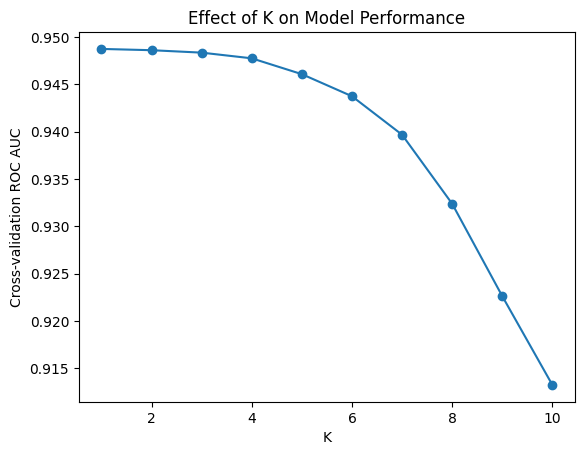

In [71]:
# Plot the cross-validation scores
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('K')
plt.ylabel('Cross-validation ROC AUC')
plt.title('Effect of K on Model Performance')
plt.show()

<a name="best-params-knn"></a>
#### Best hyperparams
Choose k neighbors before the ROC AUC decrease significantly. In this case, k=4

In [72]:
from sklearn.neighbors import KNeighborsClassifier
best_knn = KNeighborsClassifier(n_neighbors=4)
best_knn.fit(X_rest_balanced, y_rest_balanced)

KNeighborsClassifier(n_neighbors=4)

In [73]:
y_pred_knn = best_knn.predict(X_test)
probs = best_knn.predict_proba(X_test)
metrics_knn = print_metrics(y_test, y_pred_knn, probs[:, 1])

metrics_df['knn'] = metrics_knn
metrics_df


recall:  0.3125
precision:  0.2000
f1:  0.2439
roc_auc_score:  0.6718


,lr,knn
recall,0.687500,0.312500
precision,0.215686,0.200000
f1,0.328358,0.243902
roc_auc,0.801512,0.671825


### Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

param_grid = {
    'n_estimators': range(10, 300, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(10, 100, 10),
    'min_samples_split': [2, 0.01, 0.02, 0.05],
    'min_samples_leaf': [0.05, 0.1],
    'max_features': ['sqrt', 0.5, 1.0],
    'max_leaf_nodes': [None, 10, 20, 30],
    'bootstrap': [True],
}

metrics = ['recall', 'precision', 'f1', 'roc_auc']

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=50,
                                   cv=skf, n_jobs=-1, verbose=1,
                                   scoring=metrics,
                                   refit='f1',
                                   return_train_score=True,
                                   random_state=RANDOM_STATE)
random_search.fit(X_rest_balanced, y_rest_balanced)
print(random_search.best_params_) # {'n_estimators': 70, 'min_samples_split': 0.01, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 20, 'max_features': 0.5, 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
print(random_search.best_score_) # best_f1 = 0.7693

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'n_estimators': 70, 'min_samples_split': 0.01, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 20, 'max_features': 0.5, 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
0.7693666615404904


In [82]:
rf_results_df = pd.DataFrame(random_search.cv_results_)

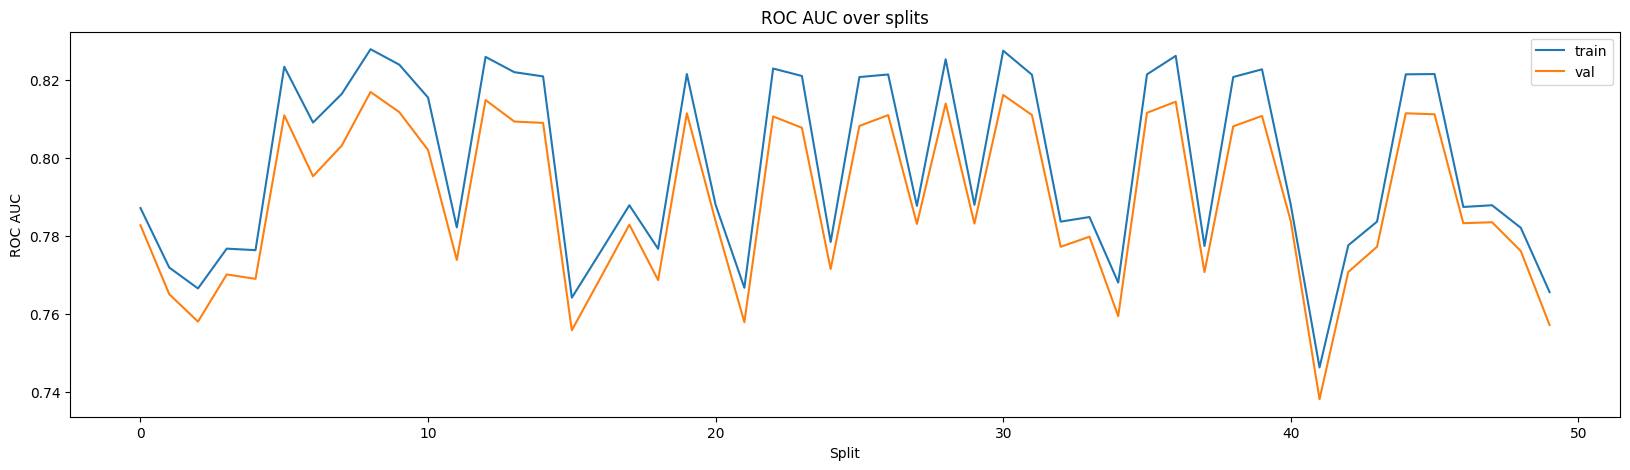

In [87]:
# Visualise the train and test scores over splits
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(rf_results_df['mean_train_roc_auc'])
plt.plot(rf_results_df['mean_test_roc_auc'])
plt.legend(['train', 'val'])
plt.title('ROC AUC over splits')
plt.ylabel('ROC AUC')
plt.xlabel('Split')
plt.show()

In [86]:
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
probs = best_rf.predict_proba(X_test)
print_metrics(y_test, y_pred_rf, probs[:, 1], False)

recall:  0.8750
precision:  0.1359
f1:  0.2353
roc_auc_score:  0.7037


In [88]:
best_rf
# RandomForestClassifier(criterion='entropy', max_depth=50, max_features=0.5,
#                        max_leaf_nodes=20, min_samples_leaf=0.05,
#                        min_samples_split=0.01, n_estimators=70, random_state=0)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features=0.5,
                       max_leaf_nodes=20, min_samples_leaf=0.05,
                       min_samples_split=0.01, n_estimators=70, random_state=0)

<a name="best-params-rf"></a>
#### Best hyperparams

In [89]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(bootstrap=True,
                                 criterion='entropy',
                                 max_depth=50,
                                 max_features=0.5,
                                 max_leaf_nodes=20,
                                 min_samples_leaf=0.05,
                                 min_samples_split=0.01,
                                 random_state=RANDOM_STATE)
best_rf.fit(X_rest_balanced, y_rest_balanced)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features=0.5,
                       max_leaf_nodes=20, min_samples_leaf=0.05,
                       min_samples_split=0.01, random_state=0)

In [90]:
y_pred_rf = best_rf.predict(X_test)
probs = best_rf.predict_proba(X_test)
metrics_rf = print_metrics(y_test, y_pred_rf, probs[:, 1])

metrics_df['rf'] = metrics_rf
metrics_df

recall:  0.8750
precision:  0.1366
f1:  0.2363
roc_auc_score:  0.6967


,lr,knn,rf
recall,0.687500,0.312500,0.875000
precision,0.215686,0.200000,0.136585
f1,0.328358,0.243902,0.236287
roc_auc,0.801512,0.671825,0.696673


### Neural network

#### Hypertuning

In [91]:
!pip install keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [92]:
from tensorflow import keras
from keras import layers, models
from keras.optimizers import Adam, SGD, Adagrad

In [93]:
y_train_balanced = y_train_balanced.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [94]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.F1Score(name='f1_score'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

initial_bias = np.log([pos/neg])

def build_model(hp: kt.HyperParameters):

  output_bias = keras.initializers.Constant(initial_bias)

  model = models.Sequential()

  model.add(layers.Flatten(input_shape=(X_train.shape[-1], )))

  # Tune the number of layers
  for i in range(hp.Int(name='num_layers', min_value=1, max_value=8, step=1)):
    model.add(layers.Dense(units=hp.Int(name=f'units_{i}', min_value=32, max_value=512, step=32),
                            activation='relu'))
    # Randomly add Dropout layer
    if hp.Boolean(name=f'add_dropout_{i}'):
      dropout_rate = hp.Float(name=f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)
      model.add(layers.Dropout(rate=dropout_rate))

    # Tune the dropout rate
    model.add(layers.Dropout(hp.Float(name=f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)))

  model.add(layers.Dense(1, activation='sigmoid',
                        bias_initializer=output_bias))

  # Optimizers
  hp_learning_rate=hp.Float(name='learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
  optimizers_dict = {
        "Adam":    Adam(learning_rate=hp_learning_rate),
        "SGD":     SGD(learning_rate=hp_learning_rate),
        "Adagrad": Adagrad(learning_rate=hp_learning_rate)
        }

  # hp_optimizers = 'Adam'
  hp_optimizers = hp.Choice(
      'optimizer',
      values=["Adam", "SGD", "Adagrad"]
      )

  model.compile(
    optimizer=optimizers_dict[hp_optimizers],
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

  return model

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective=kt.Objective(name='val_prc', direction='max'), max_trials=100, directory='nn_tuning', project_name='model' )

# Early stop
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Saving model weights
checkpoint_filepath = 'checkpoints/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, # to indicate whether or not we save the model weights
    monitor='val_prc',
    mode='max',
    save_best_only=True) # save the model weights that has the 'max' monitored metric

# Run the search
tuner.search(X_train_balanced, y_train_balanced, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint_callback])

# Get the best model
best_model = tuner.get_best_models(1)[0]

best_model.summary()

Trial 100 Complete [00h 00m 18s]
val_prc: 0.14395013451576233

Best val_prc So Far: 0.4184364676475525
Total elapsed time: 00h 50m 06s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 288)               9504      
                                                                 
 dropout_2 (Dropout)         (None, 288)             

In [ ]:
BATCH_SIZE = 16
test_results = best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
test_results

{'loss': 0.8172761797904968,
 'cross entropy': 0.5645923614501953,
 'tp': 7.0,
 'fp': 33.0,
 'tn': 388.0,
 'fn': 37.0,
 'precision': 0.17499999701976776,
 'recall': 0.15909090638160706,
 'f1_score': array([0.18918918], dtype=float32),
 'auc': 0.6123678088188171,
 'prc': 0.13039182126522064}

In [ ]:
# Uncomment to Save the best model
# best_model.save(f'{PROJECT_PATH}/best_nn_model_prc.keras')

#### Load best model and evaluate on test set

In [95]:
loaded_model = keras.models.load_model(f'{PROJECT_PATH}/best_nn_model_prc.keras')

In [ ]:
loaded_model.summary()

In [96]:
BATCH_SIZE = 16
test_results = loaded_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
test_results

{'loss': 0.31853508949279785,
 'cross entropy': 0.31853508949279785,
 'tp': 23.0,
 'fp': 40.0,
 'tn': 270.0,
 'fn': 9.0,
 'precision': 0.3650793731212616,
 'recall': 0.71875,
 'f1_score': array([0.23443225], dtype=float32),
 'auc': 0.8691532611846924,
 'prc': 0.4864807724952698}

In [97]:
y_score_nn = loaded_model.predict(X_test)
y_score_nn = y_score_nn.flatten()
y_pred_nn = np.where(y_score_nn > 0.5, 1, 0)

metrics_nn = print_metrics(y_test, y_pred_nn, y_score_nn)

metrics_df['nn'] = metrics_nn
metrics_df

11/11 [==============================] - 0s 2ms/step
recall:  0.7188
precision:  0.3651
f1:  0.4842
roc_auc_score:  0.8942


,lr,knn,rf,nn
recall,0.687500,0.312500,0.875000,0.718750
precision,0.215686,0.200000,0.136585,0.365079
f1,0.328358,0.243902,0.236287,0.484211
roc_auc,0.801512,0.671825,0.696673,0.894153


### XGBoost Classifier

#### Hypertuning

In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [ ]:
params = {
  "n_estimators": [128, 256, 384, 512],
 "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "min_split_loss" : [i/10.0 for i in range(0, 5)],
 "max_depth" : range(3, 11),
 "min_child_weight": [1, 3, 5, 7], # Minimum sum of instances needed in a child.
 "lambda": range(1, 6), # L2 regularization term on weights (xgb’s lambda).

}
xgb = XGBClassifier(
    scale_pos_weight=10, # scale_pos_weight is ratio of negative case (normal users) to positive case (anomalous users)
    eval_metric=['auc', 'aucpr'],
    random_state=RANDOM_STATE,
    )
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
metrics = ['recall', 'precision', 'f1', 'roc_auc']

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=100,
                                   scoring=metrics,
                                   cv=skf,
                                   refit='f1',
                                   n_jobs=-1,
                                   verbose=1,
                                   return_train_score=True)

random_search_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
print(f'Best params {random_search_xgb.best_params_}') # Best params {'n_estimators': 256, 'min_split_loss': 0.1, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 3}
print(f'Best f1 score {random_search_xgb.best_score_ : .4f}') # Best f1 score  0.3800

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best params {'n_estimators': 256, 'min_split_loss': 0.1, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 3}
Best f1 score  0.3800


In [ ]:
best_xgb = random_search_xgb.best_estimator_
xgb_preds = best_xgb.predict(X_test)
print(f'precision: {precision_score(y_test, xgb_preds) : .4f}')
print(f'recall: {recall_score(y_test, xgb_preds) : .4f}')
print(f'f1: {f1_score(y_test, xgb_preds) : .4f}')
print(f'roc_auc: {roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]) : .4f}')

print(f'\nNo. of classifications by xgb \n{pd.Series(xgb_preds).value_counts()}') # print to check that model is not predicting mostly 0 from class imbalance

precision:  0.1786
recall:  0.4545
f1:  0.2564
roc_auc:  0.7091

No. of classifications by xgb 
0    176
1     56
dtype: int64


In [ ]:
results = best_xgb.evals_result()
results_df = pd.DataFrame.from_dict(results)
results_df.head()

,validation_0,validation_1
auc,"[0.7827372895121555, 0.8191327359358925, 0.831...","[0.6974364498061181, 0.6894657475226196, 0.689..."
aucpr,"[0.24543682863660685, 0.2648229737329952, 0.27...","[0.14085718728756141, 0.13692284676400987, 0.1..."


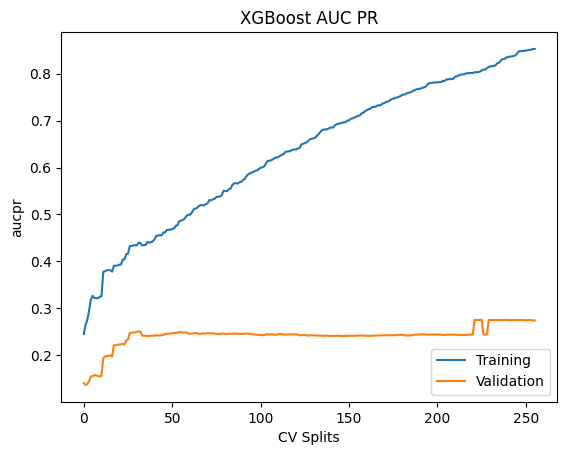

In [ ]:
# plot the training and validation AUC PR
plt.plot(results['validation_0']['aucpr'])
plt.plot(results['validation_1']['aucpr'])
plt.title('XGBoost AUC PR')
plt.ylabel('aucpr')
plt.xlabel('CV Splits')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

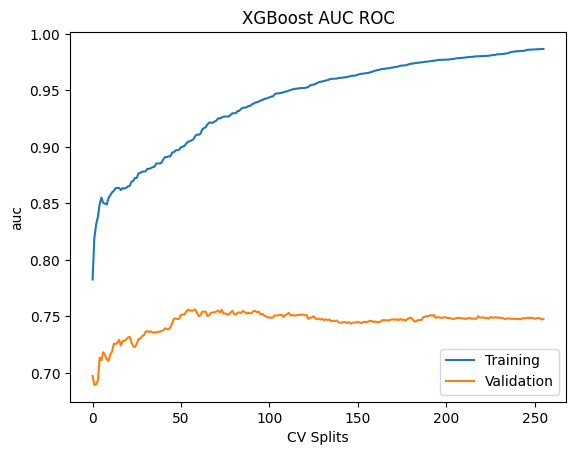

In [ ]:
# plot the training and validation AUC ROC
plt.plot(results['validation_0']['auc'])
plt.plot(results['validation_1']['auc'])
plt.title('XGBoost AUC ROC')
plt.ylabel('auc')
plt.xlabel('CV Splits')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

<a name="best-params-xgb"></a>
#### Best Hyperparams


In [99]:
# Best params {'n_estimators': 256, 'min_split_loss': 0.1, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 3}
# Best f1 score  0.3800

# precision:  0.1786
# recall:  0.4545
# f1:  0.2564
# roc_auc:  0.7091

# No. of classifications by xgb
# 0    176
# 1     56


best_xgb = XGBClassifier(
    learning_rate=0.1,
    reg_lambda=3,
    max_depth=3,
    min_child_weight=3,
    min_split_loss=0.1,
    n_estimators=256,
    scale_pos_weight=10, # scale_pos_weight is ratio of negative case (normal users) to positive case (anomalous users)
    eval_metric=['auc', 'aucpr'],
    random_state=RANDOM_STATE,
    )
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['auc', 'aucpr'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, min_split_loss=0.1,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=256, n_jobs=None, num_parallel_tree=None, ...)

In [100]:
y_pred_xgb = best_xgb.predict(X_test)
y_score_xgb = best_xgb.predict_proba(X_test)[:,1]

print(f'\nNo. of classifications by xgb \n{pd.Series(y_pred_xgb).value_counts()}\n') # print to check that model is not predicting mostly 0 from class imbalance
metrics_xgb = print_metrics(y_test, y_pred_xgb, y_score_xgb)
metrics_df['xgb'] = metrics_xgb
metrics_df



No. of classifications by xgb 
0    249
1     93
dtype: int64

recall:  0.6562
precision:  0.2258
f1:  0.3360
roc_auc_score:  0.8252


,lr,knn,rf,nn,xgb
recall,0.687500,0.312500,0.875000,0.718750,0.656250
precision,0.215686,0.200000,0.136585,0.365079,0.225806
f1,0.328358,0.243902,0.236287,0.484211,0.336000
roc_auc,0.801512,0.671825,0.696673,0.894153,0.825202


# Model Training (Unsupervised)

## Dimension Reduction (visualisation)
For visualisation of clusters to distinguish between normal and anomalous users

<a name='pca'></a>
#### PCA

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
print(f'explained variance ratio: {pca.explained_variance_ratio_}; sum of explained variance: {np.sum(pca.explained_variance_ratio_)}')
fig = px.scatter(x=X_train_pca[:,0], y=X_train_pca[:,1], color=y_train.astype(str), title='Scatter plot of PCA top two features')
fig.update_layout(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    height=600,
    width=800,

)
fig.show()

explained variance ratio: [0.50057154 0.21782053]; sum of explained variance: 0.7183920664836865


Data is not linearly seperable using PCA of 2 components, let's visualise with PCA of 3 components to see if there exists any linear separation

In [102]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
print(f'explained variance ratio: {pca.explained_variance_ratio_}; sum of explained variance: {np.sum(pca.explained_variance_ratio_)}')
fig = px.scatter_3d(x=X_train_pca[:,0], y=X_train_pca[:,1], z=X_train_pca[:,2], color=y_train.astype(str), title='Scatter plot of PCA top three features')
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3',
    ),
    height=600,
    width=800,
)
fig.show()

explained variance ratio: [0.50057154 0.21782053 0.12365795]; sum of explained variance: 0.8420500148279043


Normal and anomalous users are not linearly separable using PCA 3 components, no clear clusters separating the two.

Let's try using kernel PCA to check if there is a linear separation with 2 and 3 components

<a name='kernel-pca'></a>
#### Kernel PCA

In [103]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1, random_state=RANDOM_STATE)
X_train_kpca = kpca.fit_transform(X_train)
fig = px.scatter(x=X_train_kpca[:,0], y=X_train_kpca[:,1], color=y_train.astype(str), title='Scatter plot of kernel PCA top two features')
fig.update_layout(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    height=600,
    width=800,

)
fig.show()

In [104]:
kpca = KernelPCA(n_components=3, kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1, random_state=RANDOM_STATE)
X_train_kpca = kpca.fit_transform(X_train)
fig = px.scatter_3d(x=X_train_kpca[:,0], y=X_train_kpca[:,1], z=X_train_kpca[:,2], color=y_train.astype(str), title='Scatter plot of kernel PCA top three features')
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3',
    ),
    height=600,
    width=800,
)
fig.show()

With 2 or 3 components, data still does not seem to be linearly separable with kernel PCA.

## Autoencoder
Train the autoencoder neural network on normal users data to learn about normal user's characteristics to reconstruct normal users.

Hypothesis: Anomalous users will have higher reconstruction loss than normal users since the NN is only trained on normal users. Use the average reconstruction loss from the train set (normal users) as a threshold to make classifications on the test set (anomalous and normal users); if average reconstruction loss on test set for a user is beyond the threshold, classify the user as anomalous.


Training data: Normal users data


Validation data: normal + anomalous users data to evaluate model's ability to identify distinguish normal and anomalous users

### Split data into train (normal users) and test (normal and anomalous users)

Train set to have 70% of all normal users (only show normal users in training).

Val set to have 15% of normal users and 50% anomalous users

Test set to have 15% of normal users and 50% anomalous users

In [105]:
X = X_df.copy().to_numpy()
y = y_train_df.copy()['label'].to_numpy()

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

X_normal = X[y == 0]
X_anomalous = X[y == 1]
y_normal = y[y == 0]
y_anomalous = y[y == 1]

X_train, X_rest_normal, y_train, y_rest_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=RANDOM_STATE)
X_val_normal, X_test_normal, y_val_normal, y_test_normal = train_test_split(X_rest_normal, y_rest_normal, test_size=0.5, random_state=RANDOM_STATE)

X_val = np.concatenate((X_val_normal, X_anomalous), axis=0)
y_val = np.concatenate((y_val_normal, y_anomalous), axis=0)
X_val = shuffle(X_val, random_state=RANDOM_STATE)

X_test = np.concatenate((X_test_normal, X_anomalous), axis=0)
y_test = np.concatenate((y_test_normal, y_anomalous), axis=0)
X_test = shuffle(X_test, random_state=RANDOM_STATE)

print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'X_test.shape: {X_test.shape}')

print(f'Value count for y_val\n{pd.Series(y_val).value_counts()}', end='\n\n')
print(f'Value count for y_val\n{pd.Series(y_test).value_counts()}')

X_train.shape: (2170, 8)
X_val.shape: (785, 8)
X_test.shape: (785, 8)
Value count for y_val
0    465
1    320
dtype: int64

Value count for y_val
0    465
1    320
dtype: int64


### Standardise Data

In [108]:
# Standardise data in train, test set
# Use MinMaxScaler instead
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Autoencoder network architecture

In [109]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [110]:
class AutoEncoder(Model):
  def __init__(self, input_dim, encoding_dim):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        # optional: add more layers
        Dense(encoding_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
        # optional: add more layers
        Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [111]:
encoding_dim = 4
autoencoder = AutoEncoder(input_dim=X_train.shape[-1],
                          encoding_dim=encoding_dim)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  restore_best_weights=True)

autoencoder.compile(optimizer='adam', loss='mae')

In [112]:
epochs = 50
batch_size = 16
history = autoencoder.fit(X_train, X_train, # train set only has normal users
                          epochs=epochs, batch_size=batch_size,
                          shuffle=True, validation_data=(X_val, X_val), # validate on both normal and anomalous users
                          callbacks=[early_stopping])

Epoch 1/50
136/136 [==============================] - 1s 3ms/step - loss: 0.1984 - val_loss: 0.1446
Epoch 2/50
136/136 [==============================] - 0s 2ms/step - loss: 0.1257 - val_loss: 0.1054
Epoch 3/50
136/136 [==============================] - 0s 2ms/step - loss: 0.1056 - val_loss: 0.0940
Epoch 4/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0984 - val_loss: 0.0887
Epoch 5/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0837
Epoch 6/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0872 - val_loss: 0.0778
Epoch 7/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.0706
Epoch 8/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0615
Epoch 9/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0546
Epoch 10/50
136/136 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0491

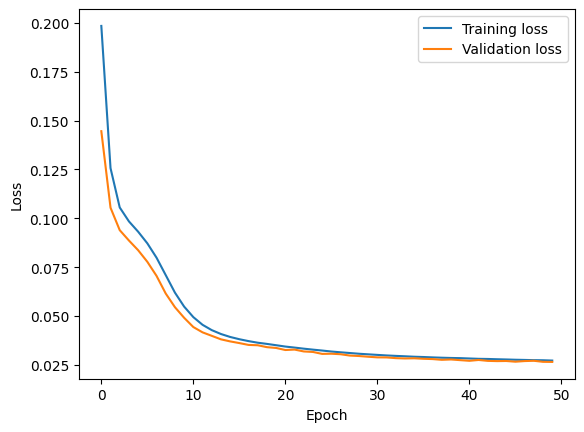

In [113]:
# plot the training and val loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualise reconstruction for test set normal users

In [114]:
X_test_normal_idx = np.where(y_test == 0)[0]
X_test_normal = X_test[X_test_normal_idx]
encoder_out = autoencoder.encoder(X_test_normal)
print(f'encoder_out.shape: {encoder_out.shape}')
decoder_out = autoencoder.decoder(encoder_out)
print(f'decoder_out.shape: {decoder_out.shape}')

encoder_out.shape: (465, 4)
decoder_out.shape: (465, 8)


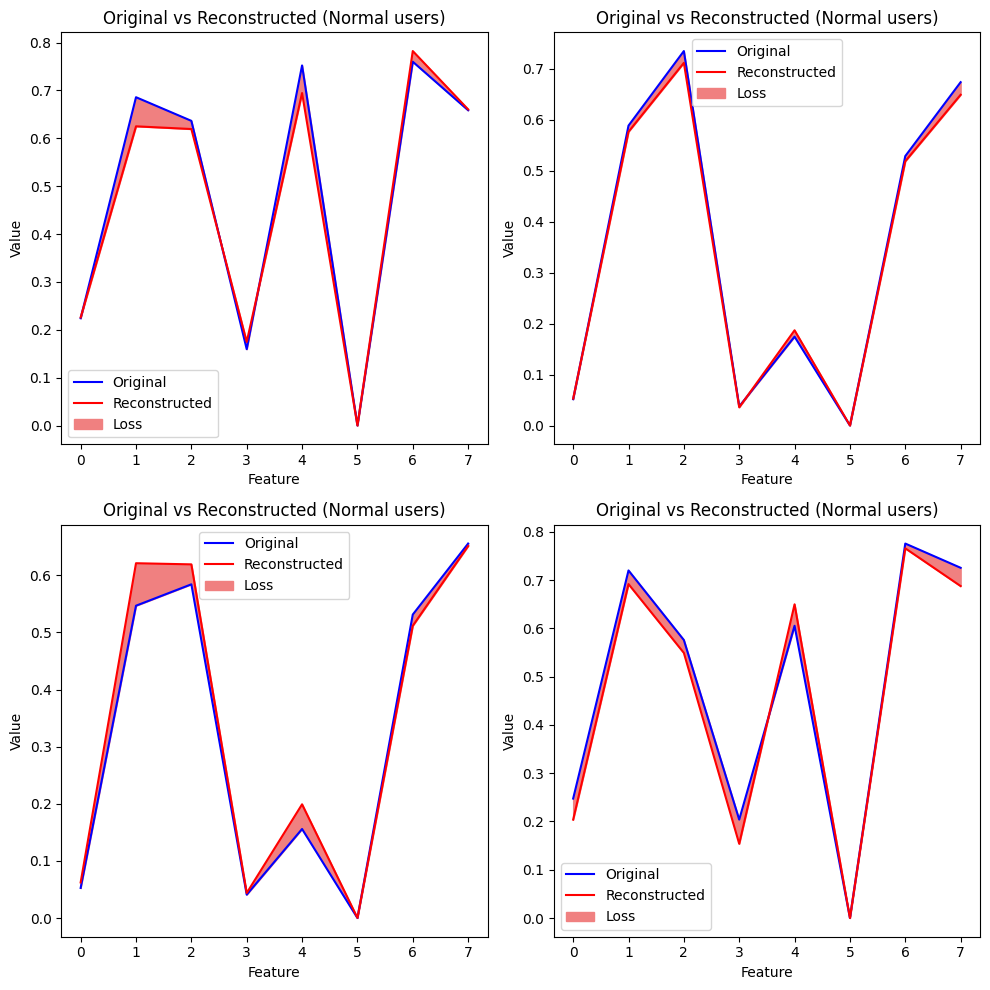

In [115]:
# plot original vs reconstructed subplots for normal users
n_rows = 2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i in range(n_rows):
  for j in range(n_cols):
    idx = i * n_cols + j
    axs[i, j].plot(X_test_normal[idx], 'b')
    axs[i, j].plot(decoder_out[idx], 'r')
    axs[i, j].set_title(f'Original vs Reconstructed (Normal users)')
    axs[i, j].fill_between(np.arange(8), decoder_out[idx], X_test_normal[idx], color='lightcoral')
    axs[i, j].legend(['Original', 'Reconstructed', 'Loss'])
    axs[i, j].set_xlabel('Feature')
    axs[i, j].set_ylabel('Value')

plt.tight_layout()
plt.show()

Expect autoencoder to reconstructs normal users quite well as it was trained on normal users.

### Visualise reconstruction for test set anomalous users

In [116]:
X_test_anomalous_idx = np.where(y_test == 1)[0]
X_test_anomalous = X_test[X_test_anomalous_idx]
encoder_out = autoencoder.encoder(X_test_anomalous)
print(f'encoder_out.shape: {encoder_out.shape}')
decoder_out = autoencoder.decoder(encoder_out)
print(f'decoder_out.shape: {decoder_out.shape}')

encoder_out.shape: (320, 4)
decoder_out.shape: (320, 8)


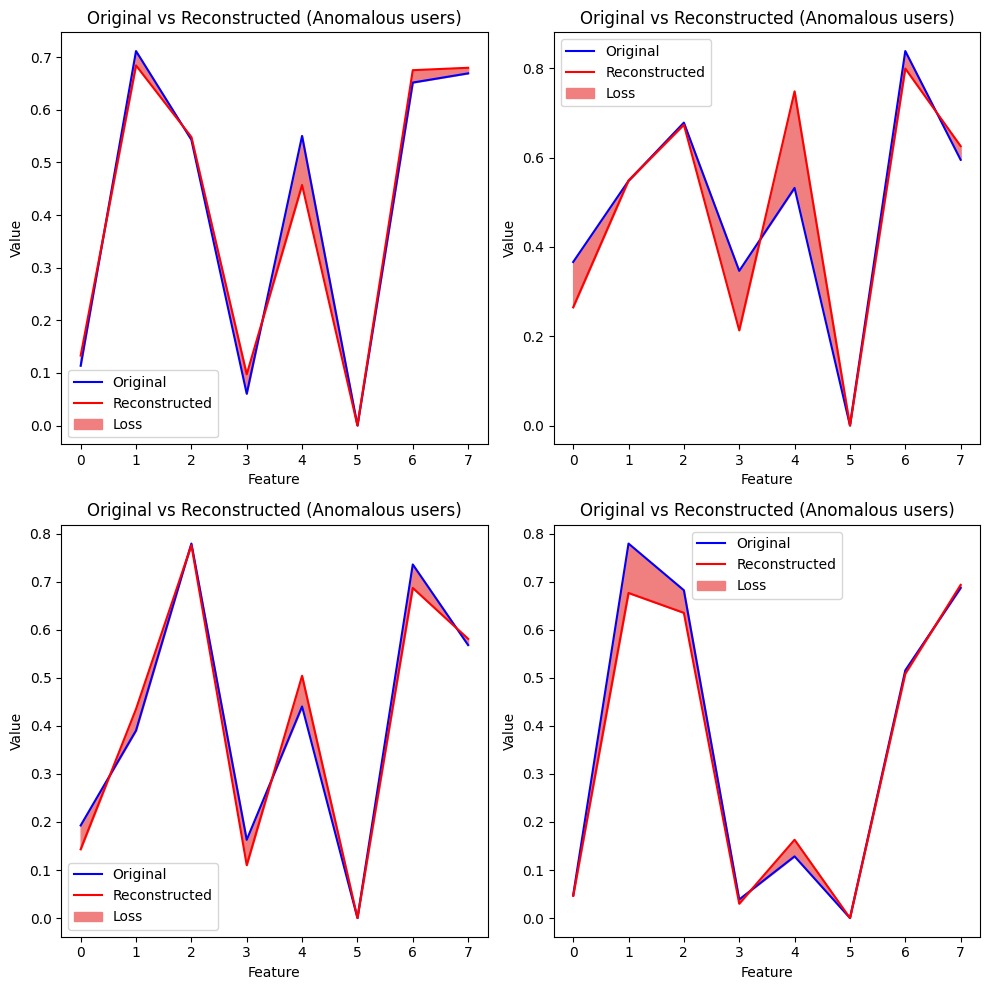

In [117]:
# plot original vs reconstructed subplots for anomalous users
n_rows = 2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i in range(n_rows):
  for j in range(n_cols):
    idx = i * n_cols + j
    axs[i, j].plot(X_test_anomalous[idx], 'b')
    axs[i, j].plot(decoder_out[idx], 'r')
    axs[i, j].set_title(f'Original vs Reconstructed (Anomalous users)')
    axs[i, j].fill_between(np.arange(8), decoder_out[idx], X_test_anomalous[idx], color='lightcoral')
    axs[i, j].legend(['Original', 'Reconstructed', 'Loss'])
    axs[i, j].set_xlabel('Feature')
    axs[i, j].set_ylabel('Value')

plt.tight_layout()
plt.show()

Expect autoencoder to be poor at reconstructing anomalous users data as the training data did not include anomalous users.

### Detect anomalies using reconstruction loss

#### Visualise reconstruction loss for normal users (train set)
Plot the reconstruction loss on the training set (normal users) to find the average loss

In [118]:
train_reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(X_train, train_reconstructions)

68/68 [==============================] - 0s 1ms/step


In [119]:
fig = px.histogram(train_loss, nbins=50)
fig.update_layout(width=800, height=600,
                  xaxis_title="Reconstruction loss",
                  yaxis_title="Count",
                  title="Reconstruction loss on training set (normal users)",
                  showlegend=False,
                  )
fig.show()

#### Visualise reconstruction loss for anomalous users (test set)

In [120]:
X_test_anomalous = X_test[y_test == 1]

test_anomalous_reconstructions = autoencoder.predict(X_test_anomalous)
test_loss_anomalous = tf.keras.losses.mae(X_test_anomalous, test_anomalous_reconstructions)

10/10 [==============================] - 0s 1ms/step


In [121]:
fig = px.histogram(test_loss_anomalous, nbins=50, color_discrete_sequence=['indianred'])
fig.update_layout(width=800, height=600,
                  xaxis_title="Reconstruction loss",
                  yaxis_title="Count",
                  title="Reconstruction loss on test set (anomalous users)",
                  showlegend=False,
                  # color='red',
                  )
# set color
# fig.update_traces()
fig.show()

It is not clear that anomalous users have larger reconstruction loss than normal users.

This could be because the features (from feature engineering) are not very good in distinguishing anomalous users from normal users; to focus again on feature engineering

#### Classify anomalies using threshold
Classify user as anomalous if the reconstruction loss is greather than the threshold

In [122]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.043320425


In [123]:
# get mean of train_loss
mean_train_loss = np.mean(train_loss)
mean_train_loss

0.027205158

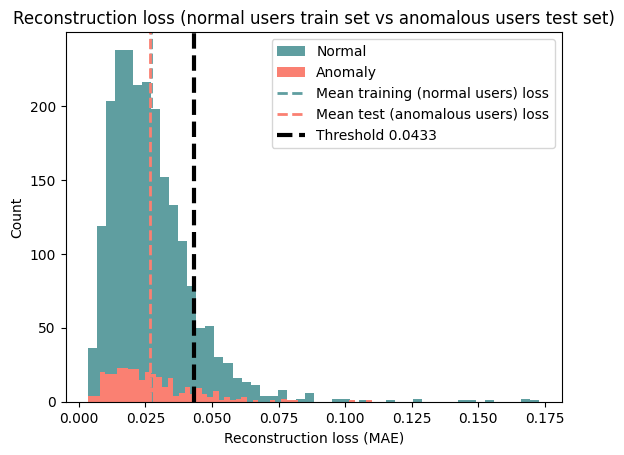

In [124]:
plt.hist(train_loss, bins=50, label='Normal', color='cadetblue')
plt.hist(test_loss_anomalous, bins=50, label='Anomaly', color='salmon')

# vertical line average training (normal users) loss
plt.axvline(np.mean(train_loss), color='cadetblue', linewidth=2, linestyle='dashed', label=f'Mean training (normal users) loss')

# vertical line average test (anomalous users) loss
plt.axvline(np.mean(test_loss_anomalous), color='salmon', linewidth=2, linestyle='dashed', label=f'Mean test (anomalous users) loss')

# vertical line threshold
plt.axvline(threshold, color='black', linewidth=3, linestyle='dashed', label=f'Threshold {threshold :.3}')

plt.legend(loc='upper right')
plt.xlabel('Reconstruction loss (MAE)')
plt.ylabel('Count')
plt.title('Reconstruction loss (normal users train set vs anomalous users test set)')
plt.show()

In [125]:
reconstructions = autoencoder.predict(X_test)
loss = tf.keras.losses.mae(X_test, reconstructions)
preds = tf.math.greater(loss, threshold)

y_pred_ae = preds.numpy()
y_score_ae = loss.numpy()

metrics_ae = print_metrics(y_test, y_pred_ae, y_score_ae)
metrics_df['ae'] = metrics_ae
metrics_df


25/25 [==============================] - 0s 1ms/step
recall:  0.1375
precision:  0.4037
f1:  0.2051
roc_auc_score:  0.4960


,lr,knn,rf,nn,xgb,ae
recall,0.687500,0.312500,0.875000,0.718750,0.656250,0.137500
precision,0.215686,0.200000,0.136585,0.365079,0.225806,0.403670
f1,0.328358,0.243902,0.236287,0.484211,0.336000,0.205128
roc_auc,0.801512,0.671825,0.696673,0.894153,0.825202,0.495968


Anomalous users do not have higher reconstruction loss than normal users; most probably because the features do not distinguish anomalous users from normal users well; to focus on feature engineering to create better features.

#### Re-run of cells
Re-run the cells again to update the training and test variables (as the variables were overwritten by autoencoder code above) e.g. if training supervised models.
- [Load data](#load-data)
- [Feature Engineering](#feature-engineering)
- [Split data](#split-data)
- [Standardise data](#standardise-data)
- [Upsampling anomalies in train set](#upsample-anomalies)

## Isolation Forest

In [146]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [274]:
X = X_df.copy().to_numpy()
y = y_train_df.copy()['label'].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [283]:
best_f1 = 0
best_params = {}
for n_estimators in [128, 256, 384, 512]:
  for max_samples in [256, 0.5, 0.8]:
    for max_features in [0.5, 0.8, 1.0]:
      for bootstrap in [True, False]:
        IF = IsolationForest(contamination=0.09, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, bootstrap=bootstrap, random_state=RANDOM_STATE)
        y_pred_if = IF.fit_predict(X)
        y_pred_if = np.where(y_pred_if == -1, 1, 0)
        f1 = f1_score(y, y_pred_if)
        if f1 > best_f1:
          best_f1 = f1
          best_params = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features, 'bootstrap': bootstrap}
print(f'Best f1: {best_f1}') # Best f1: 0.05
print(f'Best params: {best_params}') # Best params: {'n_estimators': 128, 'max_samples': 0.8, 'max_features': 1.0, 'bootstrap': True}

Best f1: 0.05414012738853503
Best params: {'n_estimators': 128, 'max_samples': 0.8, 'max_features': 1.0, 'bootstrap': True}


In [286]:
best_if = IsolationForest(contamination=0.09, n_estimators=128, max_samples=0.8, max_features=1.0, bootstrap=True, random_state=RANDOM_STATE)
y_pred_if = best_if.fit_predict(X)
y_pred_if = np.where(y_pred_if == -1, 1, 0)

In [288]:
print(f'Accuracy: {accuracy_score(y, y_pred_if) : .2f}')
print(f'Recall: {recall_score(y, y_pred_if) : .2f}')
print(f'Precision: {precision_score(y, y_pred_if) : .2f}')
print(f'F1: {f1_score(y, y_pred_if) : .2f}')

Accuracy:  0.83
Recall:  0.05
Precision:  0.06
F1:  0.05


Isolation forest is poor in identifying anomalies based on the features we have. Exclude isolation forest's predictions from the ensemble models.

## Local Outlier Factor (LOF)

In [150]:
from sklearn.neighbors import LocalOutlierFactor

### Novelty Detection (`lof_nd`)
Approach: As we have labels (normal or anomalous) for our data, we can use LOF for novelty detection.
- fit the LOF model (`novelty=True`) on only normal users,
- tune the `n_neighbors` hyperparameter to maximise the accuracy score on test set (all anomalous users)


##### Splitting data
Train set: All normal users

Test set: All anomalous users

In [236]:
X = X_df.copy().to_numpy()
y = y_train_df.copy()['label'].to_numpy()

In [237]:
X_train = X[y == 0]
y_train = y[y == 0]
X_anomalous = X[y == 1]
y_anomalous = y[y == 1]

##### Standardising data

In [238]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_anomalous = scaler.transform(X_anomalous)


##### Finding best `n_neighbors`

In [241]:
scores = []
for n_neighbors in range(3, 31):
  lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True)
  lof.fit(X_train)
  y_pred_lof_nd = lof.predict(X_anomalous)
  y_pred_lof_nd = np.where(y_pred_lof_nd == -1, 1, 0)

  score = accuracy_score(y_anomalous, y_pred_lof_nd) # check accuracy since y_val_anomalous is all 1's, ideally, preds should contain as much 1 as possible
  scores.append(score)


In [244]:
# plot the f1 scores across n_neighbors
fig = px.line(x=range(3, 31), y=scores, title='Accuracy scores in identifying anomalies according to n_neighbors in LOF Novelty Detection')
fig.update_xaxes(title='n_neighbors')
fig.update_yaxes(title='Accuracy')

The accuracy is very poor.. LOF novelty detection does not perform well in identifying anomalies from our features (also as seen from [PCA](#pca) and [kernel PCA visualisations](#kernel-pca) that the normal and anomalous users are very mixed together with no clear separation).

### Anomaly Detection (`lof_od`)
Approach: Use LOF as outlier detection (od). As LOF is an unsupervised method but since we have labelled data (normal or anomalous user),
- fit the LOF model on entire train set (including both normal and anomalous users)
- tune `n_neighbors` that maximises f1 score on the val set
- use the best LOF model (whose `n_neighbors` have the highest f1 score) 's predictions as part of the voting for `lof_ad` model in the ensemble approach.

In [257]:
X = X_df.copy().to_numpy()
y = y_train_df.copy()['label'].to_numpy()

##### Standardising data

In [258]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

##### Finding best `n_neighbors`

In [259]:
scores = []
for n_neighbors in range(3, 31):
  lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=False)
  y_pred_lof_ad = lof.fit_predict(X)
  y_pred_lof_ad = np.where(y_pred_lof_ad == -1, 1, 0)

  score = f1_score(y, y_pred_lof_ad)
  scores.append(score)


In [260]:
# plot the f1 scores across different neighbors
fig = px.line(x=range(3, 31), y=scores, title='F1 scores in identifying anomalies according to n_neighbors in LOF Anomaly Detection')
fig.update_xaxes(title='n_neighbors')
fig

##### Generate predictions

In [263]:
n_neighbors = 6
best_lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=False)
y_pred_lof_ad = best_lof.fit_predict(X)
y_pred_lof_ad = np.where(y_pred_lof_ad == -1, 1, 0)

In [264]:
print(f'Accuracy: {accuracy_score(y, y_pred_lof_ad) : .2f}')
print(f'Recall: {recall_score(y, y_pred_lof_ad) : .2f}')
print(f'Precision: {precision_score(y, y_pred_lof_ad) : .2f}')
print(f'F1: {f1_score(y, y_pred_lof_ad) : .2f}')

Accuracy:  0.89
Recall:  0.02
Precision:  0.10
F1:  0.03


Using LOF outlier detection does not perform well in identifying anomalies based on the features we have. Exclude `lof_od`'s predictions from the ensemble models.

# Plot ROC AUC for Models

8/8 [==============================] - 0s 3ms/step


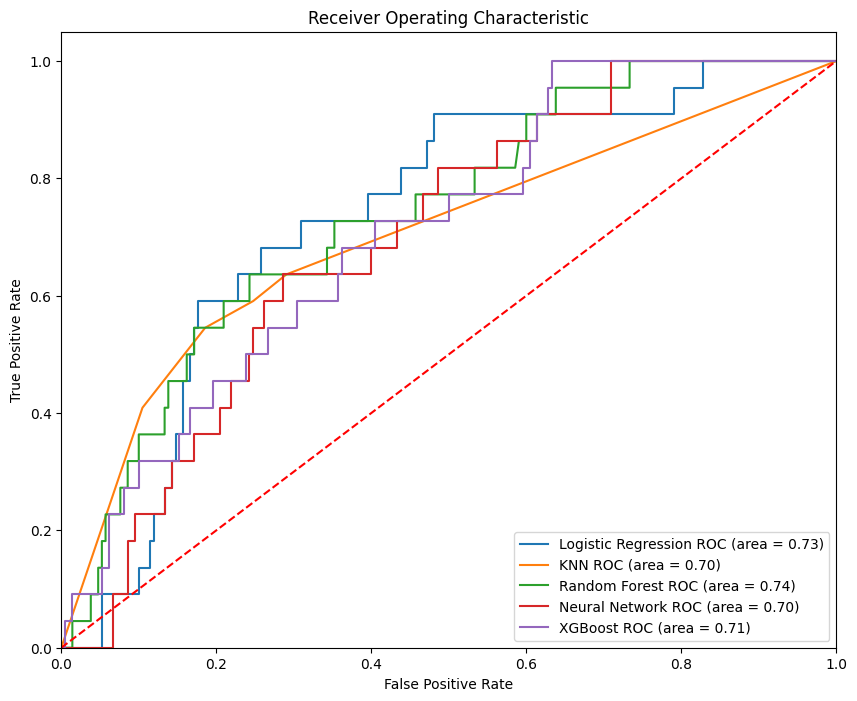

In [ ]:
# ROC AUC Curves for multiple models
from sklearn import metrics

def plot_roc_curve(plt, y_test, y_score, label=None):
  fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
  auc = metrics.roc_auc_score(y_test, y_score)
  plt.plot(fpr, tpr, label=f'{label} (area = {auc : .2f})')

plt.figure(figsize=(10, 8))

# logistic regression
y_score_lr = lr.predict_proba(X_test)[:, 1]
plot_roc_curve(plt, y_test, y_score_lr, 'Logistic Regression')

# knn
y_score_knn = best_knn.predict_proba(X_test)[:, 1]
plot_roc_curve(plt, y_test, y_score_knn, 'KNN')

# random forest
y_score_rf = best_rf.predict_proba(X_test)[:, 1]
plot_roc_curve(plt, y_test, y_score_rf, 'Random Forest')

# nn
y_score_nn = loaded_model.predict(X_test)
y_score_nn = y_score_nn.flatten()
plot_roc_curve(plt, y_test, y_score_nn, 'Neural Network')

# xgb
y_score_xgb = best_xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(plt, y_test, y_score_xgb, 'XGBoost')

# Plot the diagonal line
plt.plot([0, 1], [0, 1],'r--')

# Custom settings for the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
metrics_df

,lr,knn,rf,nn,xgb,ae
recall,0.909091,0.545455,0.363636,0.318182,0.454545,0.145455
precision,0.136054,0.235294,0.222222,0.175000,0.178571,0.415584
f1,0.236686,0.328767,0.275862,0.225806,0.256410,0.215488
roc_auc,0.732251,0.702056,0.737554,0.695887,0.709091,0.498745


---

# Ensemble Approach to Classify Evaluation/Batch Test Data
Classify a user as normal or anomalous according to majority classification from all models, equal vote weightage.

## Load training data

In [289]:
X_train_p1,y_train_p1 = load_data(TRAIN_DATA_PATH_P1)
X_train_p2,y_train_p2 = load_data(TRAIN_DATA_PATH_P2)
X_train_p3,y_train_p3 = load_data(TRAIN_DATA_PATH_P3)

X_train_p1_df, X_train_p2_df, X_train_p3_df = load_X(X_train_p1, 'phase 1'), load_X(X_train_p2, 'phase 2'), load_X(X_train_p3, 'phase 3')
y_train_p1_df, y_train_p2_df, y_train_p3_df = load_y(y_train_p1, 'phase 1'), load_y(y_train_p2, 'phase 2'), load_y(y_train_p3, 'phase 3')

# To account for repeated userid (but represent different users) in p1 and p2 train data and labels set
min_user_id = X_train_p1_df['user'].min()
X_train_p1_df['user'] = X_train_p1_df['user'] - min_user_id
y_train_p1_df['user'] = y_train_p1_df['user'] - min_user_id

X_train_df = pd.concat([X_train_p1_df, X_train_p2_df, X_train_p3_df], ignore_index=True)
y_train_df = pd.concat([y_train_p1_df, y_train_p2_df, y_train_p3_df], ignore_index=True)

Data files found in path training_data_with_labels.npz: ['X', 'y']
Data files found in path first_batch_test_with_labels.npz: ['X', 'y']
Data files found in path second_batch_test_with_labels.npz: ['X', 'y']
loading X data for phase 1
# of interactions: 195762
# of items: 1192

loading X data for phase 2
# of interactions: 201649
# of items: 1195

loading X data for phase 3
# of interactions: 210680
# of items: 1192

loading y data for phase 1
# of users: 1100
0    1000
1     100
Name: label, dtype: int64

loading y data for phase 2
# of users: 1100
0    1000
1     100
Name: label, dtype: int64

loading y data for phase 3
# of users: 1220
0    1100
1     120
Name: label, dtype: int64



In [290]:
X_train_df = transform_X(X_train_df)
X_train_df

,num_interactions,ratings_mean,ratings_skew,num_unpopular_items_rated,num_popular_items_rated,unpopular_item_ratio,entropy,rating_deviation
0,88,3.147727,-0.230950,59,29.0,2.034483,6.459432,-24.0
1,363,1.862259,0.484734,277,86.0,3.220930,8.503826,-546.5
2,52,4.269231,-0.963058,30,22.0,1.363636,5.700440,56.0
3,173,3.393064,-0.054304,138,35.0,3.942857,7.434628,-42.0
4,92,4.184783,-1.374578,66,26.0,2.538462,6.523562,66.0
...,...,...,...,...,...,...,...,...
3415,170,3.523529,-0.969183,118,52.0,2.269231,7.409391,29.0
3416,206,3.699029,-0.529586,157,49.0,3.204082,7.686501,65.0
3417,247,3.117409,-0.433839,193,54.0,3.574074,7.948367,-69.0
3418,85,3.741176,-0.675425,54,31.0,1.741935,6.409391,-5.0


In [291]:
X_train_df.describe()

,num_interactions,ratings_mean,ratings_skew,num_unpopular_items_rated,num_popular_items_rated,unpopular_item_ratio,entropy,rating_deviation
count,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000
mean,177.804386,3.512302,-0.507309,128.092982,49.711407,38.015068,6.935520,-18.175146
std,148.345163,0.474682,0.570145,123.543545,28.846332,646.515781,1.344765,102.584232
min,2.000000,0.831461,-7.681146,1.000000,0.001000,0.076923,1.000000,-1007.000000
25%,65.000000,3.225605,-0.783354,38.000000,25.000000,1.450000,6.022368,-43.500000
50%,133.000000,3.531080,-0.459053,85.000000,47.000000,2.142857,7.055282,-1.000000
75%,252.000000,3.828412,-0.173664,181.000000,73.000000,3.000000,7.977280,24.000000
max,988.000000,5.000000,1.700435,879.000000,109.000000,14000.000000,9.948367,494.500000


## Load batch test data

In [292]:
X_batch_test_df = load_X(load_data(TEST_DATA_PATH)[0])
X_batch_test_df = transform_X(X_batch_test_df)
X_batch_test_df

Data files found in path third_batch_test.npz: ['X']
# of interactions: 349573
# of items: 1194



,num_interactions,ratings_mean,ratings_skew,num_unpopular_items_rated,num_popular_items_rated,unpopular_item_ratio,entropy,rating_deviation
0,105,2.904762,-0.812471,42,63.0,0.666667,6.714246,-76.0
1,100,3.770000,0.033824,39,61.0,0.639344,6.643856,24.0
2,32,4.000000,0.000000,22,10.0,2.200000,5.000000,4.5
3,63,3.365079,-0.198908,46,17.0,2.705882,5.977280,-16.0
4,221,3.475113,-0.150163,147,74.0,1.986486,7.787903,-68.5
...,...,...,...,...,...,...,...,...
1995,73,3.726027,-0.644028,44,29.0,1.517241,6.189825,15.0
1996,415,3.477108,-0.505826,334,81.0,4.123457,8.696968,43.5
1997,120,2.925000,-0.583857,92,28.0,3.285714,6.906891,-62.5
1998,60,3.416667,-0.410145,40,20.0,2.000000,5.906891,7.0


In [293]:
X_batch_test_df.describe()

,num_interactions,ratings_mean,ratings_skew,num_unpopular_items_rated,num_popular_items_rated,unpopular_item_ratio,entropy,rating_deviation
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,174.786500,3.513051,-0.533072,128.012500,46.774003,17.004723,6.890485,-18.511000
std,146.565482,0.476177,0.533577,122.921329,27.530522,311.877836,1.375631,106.903157
min,2.000000,0.724138,-3.137755,1.000000,0.001000,0.035714,1.000000,-1128.000000
25%,61.000000,3.240556,-0.812359,36.000000,23.000000,1.518199,5.930737,-41.500000
50%,133.500000,3.528851,-0.496122,88.000000,44.000000,2.298936,7.060686,-1.000000
75%,252.000000,3.825857,-0.191848,182.250000,70.000000,3.238248,7.977280,25.000000
max,917.000000,5.000000,1.658446,820.000000,100.000000,9000.000000,9.840778,384.500000


## Standardise data
Transform the batch test set from the entire train set (for final evaluation on batch test set)

In [294]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_batch_test_df)

# Check mean ~ 0 and std = 1 for train dataset
print(X_train.mean(axis=0))
print(X_train.std(axis=0), end='\n\n')

[-2.49313241e-17  1.03880517e-18  3.73969861e-17 -8.93372446e-17
  4.72656352e-17 -1.03880517e-18  1.06996932e-16 -1.66208827e-17]
[1. 1. 1. 1. 1. 1. 1. 1.]



## Upsampling anomalies in train set

In [295]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

y_train = y_train_df['label']

# Summarize class distribution
print("Original class distribution y_train:", Counter(y_train))
print(f'X_train before oversampling: {X_train.shape}')
print()

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the transform
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train) # exclude oversampling val set for neural network

print("After oversampling y train:", Counter(y_train_balanced))
print(f'X_train after oversampling: {X_train_balanced.shape}')

Original class distribution y_train: Counter({0: 3100, 1: 320})
X_train before oversampling: (3420, 8)

After oversampling y train: Counter({1: 3100, 0: 3100})
X_train after oversampling: (6200, 8)


## Logistic Regression

In [296]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
lr = LogisticRegressionCV(cv=skf, max_iter=1000, scoring='roc_auc', n_jobs=-1)
lr.fit(X_train_balanced, y_train_balanced)

y_pred_lr = lr.predict(X_test)
print(f'\nNo. of classifications by Logistic Regression \n{pd.Series(y_pred_lr).value_counts()}') # check model is not predicting mostly 0 against class imbalance


No. of classifications by Logistic Regression 
0    1193
1     807
dtype: int64


## KNN Classifier
[KNN Classifier Best Hyperparams](#best-params-knn)

In [297]:
from sklearn.neighbors import KNeighborsClassifier

# Choose k = 4
best_knn = KNeighborsClassifier(n_neighbors=4)
best_knn.fit(X_train_balanced, y_train_balanced)
y_pred_knn = best_knn.predict(X_test)
print(f'\nNo. of classifications by KNN classifier \n{pd.Series(y_pred_knn).value_counts()}')


No. of classifications by KNN classifier 
0    1657
1     343
dtype: int64


## Random Forest
[Random Forest Classifier Best Hyperparams](#best-params-rf)

In [299]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

best_rf = RandomForestClassifier(bootstrap=True,
                                 criterion='entropy',
                                 max_depth=50,
                                 max_features=0.5,
                                 max_leaf_nodes=20,
                                 min_samples_leaf=0.05,
                                 min_samples_split=0.01,
                                 random_state=RANDOM_STATE)

best_rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = best_rf.predict(X_test)
print(f'\nNo. of classifications by Random Forest classifier \n{pd.Series(y_pred_rf).value_counts()}')


No. of classifications by Random Forest classifier 
0    1072
1     928
dtype: int64


## Neural Network

In [300]:
y_train_balanced = y_train_balanced.astype('float32')

In [301]:
loaded_model = keras.models.load_model(f'{PROJECT_PATH}/best_nn_model_prc.keras')

In [302]:
y_pred_nn = loaded_model.predict(X_test)
y_pred_nn.shape

63/63 [==============================] - 0s 2ms/step


(2000, 1)

In [303]:
# Convert to 1 if > 0.5 else 0
y_pred_nn = np.where(y_pred_nn.flatten() > 0.5, 1, 0)
print(pd.Series(y_pred_nn).value_counts())

0    1631
1     369
dtype: int64


## XGBoost Classifier

[XGBoost Classifier Best Hyperparams](#best-params-xgb)

In [304]:
best_xgb = XGBClassifier(
    learning_rate=0.1,
    reg_lambda=3,
    max_depth=3,
    min_child_weight=3,
    min_split_loss=0.1,
    n_estimators=256,
    scale_pos_weight=10, # scale_pos_weight is ratio of negative case (normal users) to positive case (anomalous users)
    eval_metric=['auc', 'aucpr'],
    random_state=RANDOM_STATE,
    )
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['auc', 'aucpr'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, min_split_loss=0.1,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=256, n_jobs=None, num_parallel_tree=None, ...)

In [305]:
xgb_preds = best_xgb.predict(X_test)
print(f'\nNo. of classifications by xgb \n{pd.Series(xgb_preds).value_counts()}') # print to check that model is not predicting mostly 0 from class imbalance


No. of classifications by xgb 
0    1478
1     522
dtype: int64


## Final predictions

In [306]:
preds_df = pd.DataFrame({
    'pred_lr': y_pred_lr,
    'pred_knn': y_pred_knn,
    'pred_rf': y_pred_rf,
    'pred_nn': y_pred_nn,
    'pred_xgb': xgb_preds,
})

preds_df['pred'] = preds_df[['pred_nn', 'pred_xgb', 'pred_lr', 'pred_knn', 'pred_rf']].mode(axis=1).iloc[:, 0]
preds_df

,pred_lr,pred_knn,pred_rf,pred_nn,pred_xgb,pred
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,1,0,1,1,0,1
3,1,1,1,1,1,1
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1995,1,1,1,1,1,1
1996,0,0,0,0,0,0
1997,1,0,1,0,0,0
1998,1,1,1,1,1,1


In [307]:
# output to csv
preds_df[['pred']].to_csv(f'{PROJECT_PATH}/ensemble_preds.csv', index=True)